# Data Analytics Project - Models

# Pair 3 - TATAMOTORS LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 1 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

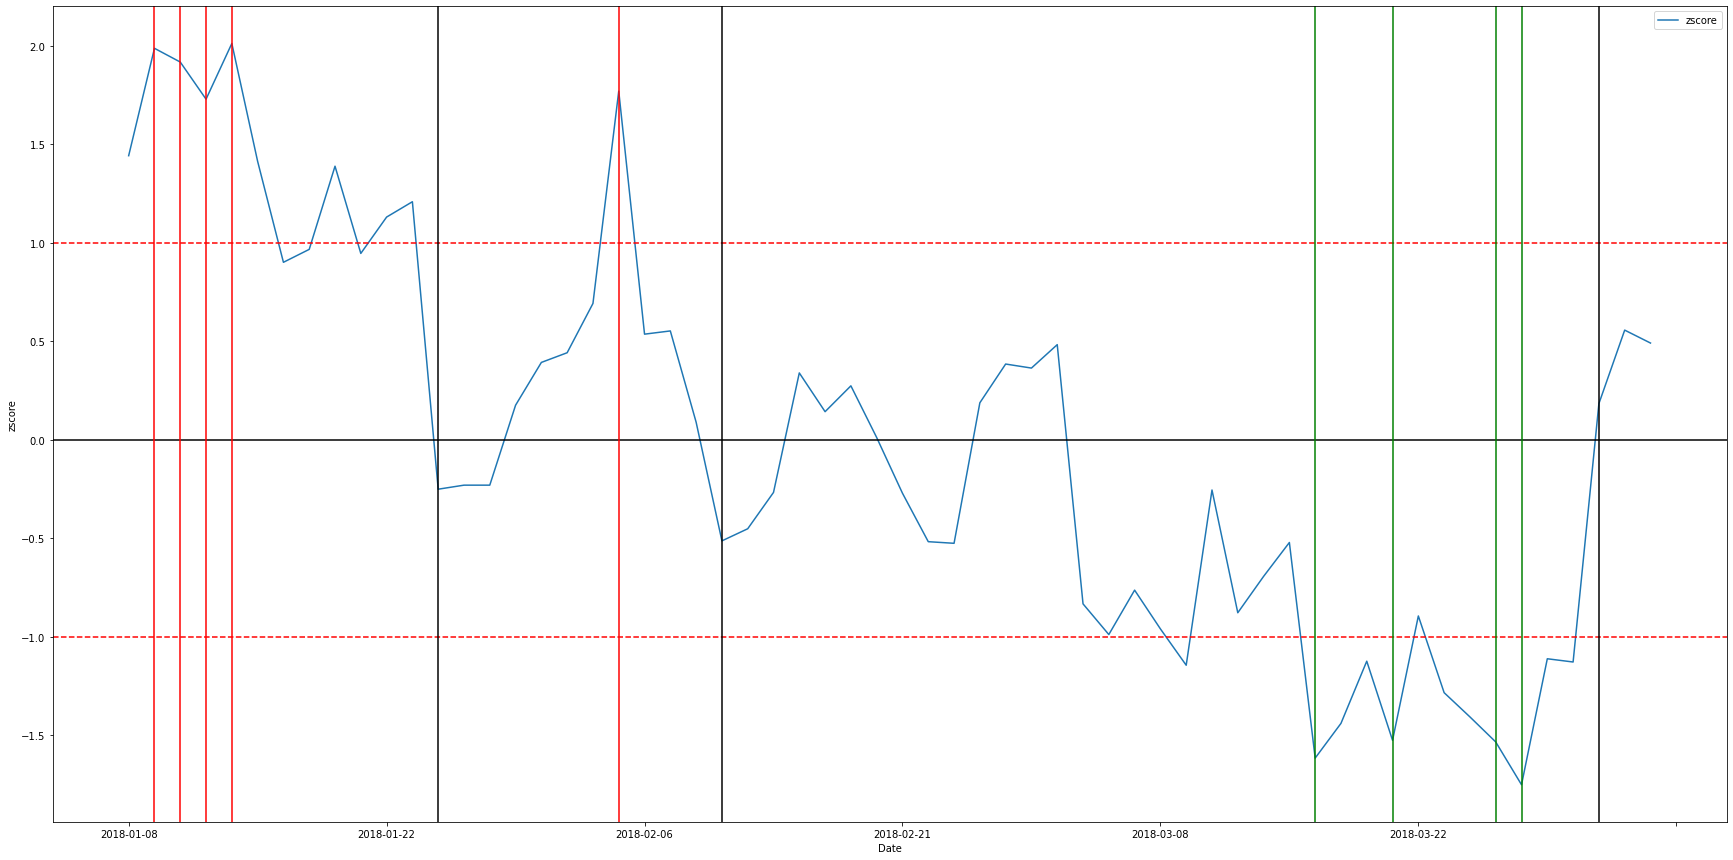

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

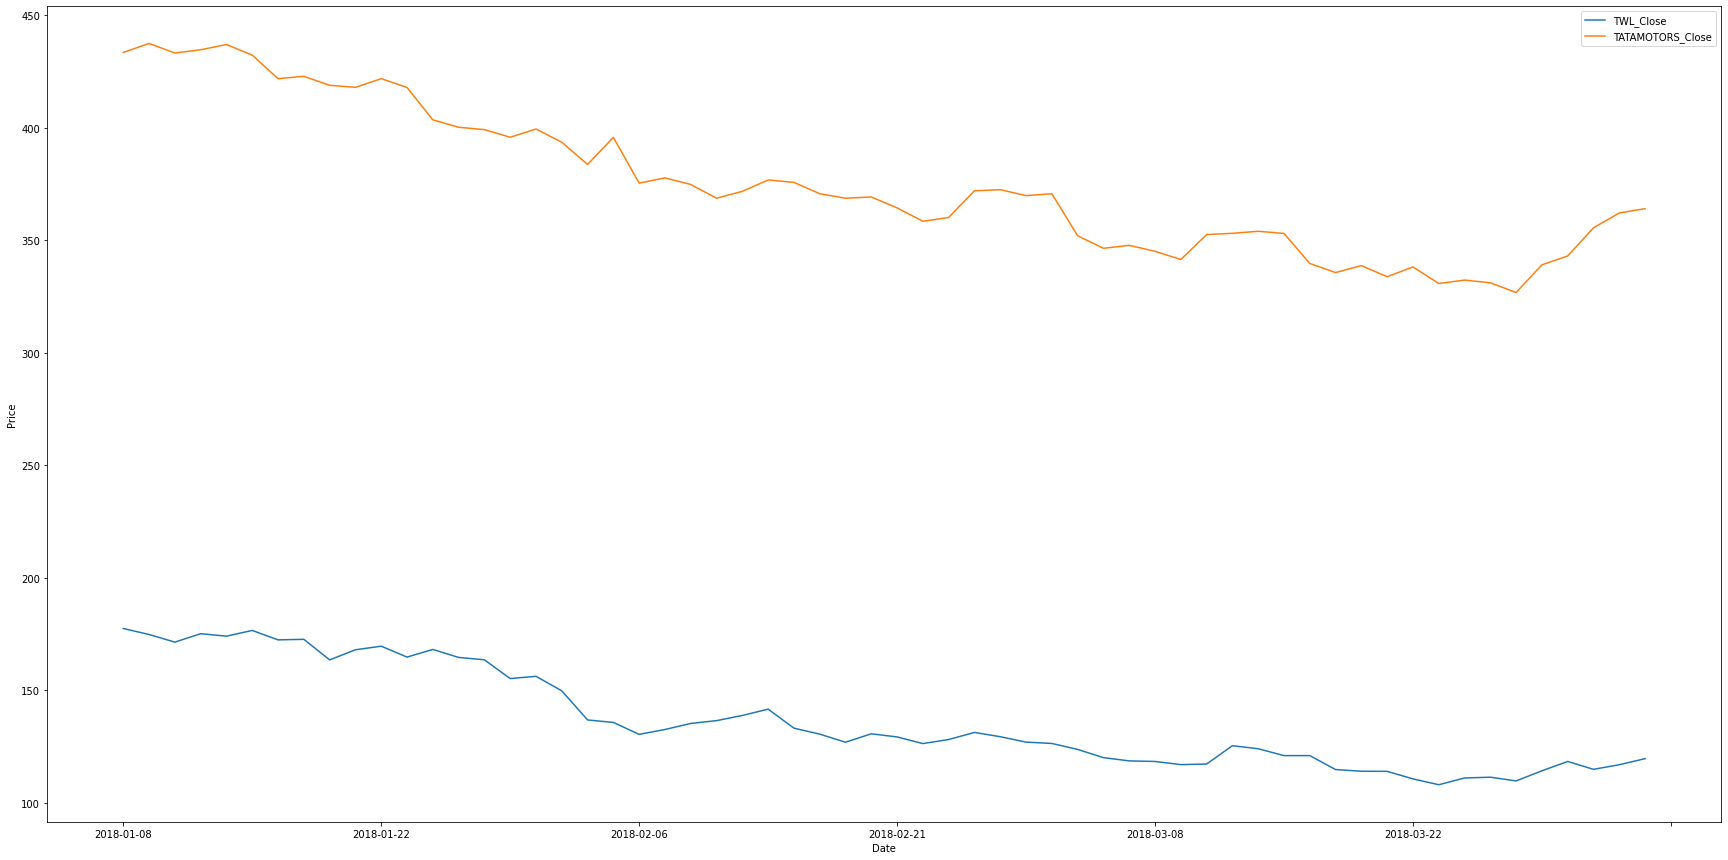

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TWL_Close', 'TATAMOTORS_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TATAMOTORS Linear Regression Model

## 3.1. Get the Complete TATAMOTORS dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TATAMOTORSNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,488.700012,469.049988,472.000000,487.049988,4024156.0,487.049988,TATAMOTORS,NSE
1,2017-01-03,492.700012,479.899994,491.000000,481.100006,5814518.0,481.100006,TATAMOTORS,NSE
2,2017-01-04,493.700012,484.100006,484.649994,486.649994,4769872.0,486.649994,TATAMOTORS,NSE
3,2017-01-05,503.399994,495.549988,496.000000,502.149994,7961242.0,502.149994,TATAMOTORS,NSE
4,2017-01-06,507.950012,496.250000,502.950012,497.750000,4907475.0,497.750000,TATAMOTORS,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TATAMOTORS training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,487.049988
1,2017-01-03,481.100006
2,2017-01-04,486.649994
3,2017-01-05,502.149994
4,2017-01-06,497.750000


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,383.399994
167,2017-09-05,388.149994
168,2017-09-06,382.700012
169,2017-09-07,378.149994
170,2017-09-08,375.049988


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,261.700012
413,2018-08-30,259.350006
414,2018-08-31,267.500000
415,2018-09-03,266.600006
416,2018-09-04,261.950012


### 3.2.3 Get the training data

In [10]:
tata_train = tata_df_train.copy()

In [11]:
tata_train = tata_train.reset_index(drop=True)
tata_train = tata_train.copy()
tata_train.head()

,Date,Close
0,2017-09-04,383.399994
1,2017-09-05,388.149994
2,2017-09-06,382.700012
3,2017-09-07,378.149994
4,2017-09-08,375.049988


In [12]:
tata_train_plot_copy = tata_train.copy()
tata_train.tail()

,Date,Close
246,2018-08-29,261.700012
247,2018-08-30,259.350006
248,2018-08-31,267.500000
249,2018-09-03,266.600006
250,2018-09-04,261.950012


In [13]:
tata_train = tata_train.drop(columns=['Date'])
tata_train = tata_train.values
tata_train

array([[383.3999939 ],
       [388.1499939 ],
       [382.70001221],
       [378.1499939 ],
       [375.04998779],
       [375.29998779],
       [388.25      ],
       [389.6499939 ],
       [404.3999939 ],
       [401.75      ],
       [404.95001221],
       [423.6499939 ],
       [414.79998779],
       [413.6499939 ],
       [411.79998779],
       [408.20001221],
       [411.25      ],
       [404.8999939 ],
       [401.3999939 ],
       [401.5       ],
       [416.        ],
       [423.54998779],
       [423.29998779],
       [424.8500061 ],
       [425.6000061 ],
       [423.6000061 ],
       [415.5       ],
       [420.1499939 ],
       [424.79998779],
       [437.04998779],
       [432.29998779],
       [433.20001221],
       [426.95001221],
       [422.75      ],
       [416.04998779],
       [421.95001221],
       [419.3999939 ],
       [429.8999939 ],
       [436.54998779],
       [428.3999939 ],
       [437.75      ],
       [434.8999939 ],
       [447.70001221],
       [462

In [14]:
len(tata_train)

251

## 3.3. Get TATAMOTORS Test Data

In [15]:
tata_test = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test.head()

,Date,Close
416,2018-09-04,261.950012
417,2018-09-05,266.500000
418,2018-09-06,269.950012
419,2018-09-07,277.399994
420,2018-09-10,275.700012


In [16]:
tata_test.tail()

,Date,Close
470,2018-11-27,180.050003
471,2018-11-28,174.449997
472,2018-11-29,177.250000
473,2018-11-30,171.949997
474,2018-12-03,175.449997


In [17]:
tata_test.reset_index(drop=True, inplace=True)
tata_test.index += 251
tata_test.head()

,Date,Close
251,2018-09-04,261.950012
252,2018-09-05,266.500000
253,2018-09-06,269.950012
254,2018-09-07,277.399994
255,2018-09-10,275.700012


In [18]:
tata_test_plot_copy = tata_test.copy()
tata_test = tata_test.drop(columns=['Date'])
tata_test = tata_test.values
tata_test

array([[261.95001221],
       [266.5       ],
       [269.95001221],
       [277.3999939 ],
       [275.70001221],
       [267.29998779],
       [262.3999939 ],
       [266.6000061 ],
       [260.25      ],
       [251.5       ],
       [252.6000061 ],
       [250.3500061 ],
       [240.19999695],
       [240.80000305],
       [233.3500061 ],
       [225.25      ],
       [223.69999695],
       [229.3500061 ],
       [227.6000061 ],
       [223.25      ],
       [216.25      ],
       [212.3500061 ],
       [184.3500061 ],
       [188.75      ],
       [182.94999695],
       [183.75      ],
       [184.3500061 ],
       [185.8500061 ],
       [179.94999695],
       [174.69999695],
       [170.75      ],
       [170.6499939 ],
       [170.6499939 ],
       [165.3500061 ],
       [168.5       ],
       [175.3500061 ],
       [177.25      ],
       [179.1000061 ],
       [179.44999695],
       [190.30000305],
       [189.80000305],
       [193.25      ],
       [194.8500061 ],
       [195

In [19]:
len(tata_test)

59

## 3.4 Create and Train TATAMOTORS Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(tata_train)
scaled_train_data

array([[6.28851535e-01],
       [6.51027073e-01],
       [6.25583647e-01],
       [6.04341731e-01],
       [5.89869247e-01],
       [5.91036380e-01],
       [6.51493954e-01],
       [6.58029874e-01],
       [7.26890752e-01],
       [7.14519165e-01],
       [7.29458532e-01],
       [8.16760035e-01],
       [7.75443479e-01],
       [7.70074693e-01],
       [7.61437877e-01],
       [7.44631268e-01],
       [7.58870240e-01],
       [7.29225019e-01],
       [7.12885150e-01],
       [7.13352032e-01],
       [7.81045777e-01],
       [8.16293153e-01],
       [8.15126019e-01],
       [8.22362333e-01],
       [8.25863733e-01],
       [8.16526665e-01],
       [7.78711510e-01],
       [8.00420165e-01],
       [8.22128821e-01],
       [8.79318364e-01],
       [8.57142827e-01],
       [8.61344621e-01],
       [8.32166283e-01],
       [8.12558382e-01],
       [7.81279147e-01],
       [8.08823612e-01],
       [7.96918765e-01],
       [8.45938373e-01],
       [8.76984097e-01],
       [8.38935572e-01],


In [21]:
X_train, y_train = [], []
for i in range(10,len(tata_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0116


## 3.5. Get predictions

In [24]:
scaled_test_data = tata_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.06185815,  0.08309992,  0.09920642,  0.13398692,  0.12605049,
         0.08683469,  0.0639589 ,  0.0835668 ,  0.05392158,  0.01307191],
       [ 0.08309992,  0.09920642,  0.13398692,  0.12605049,  0.08683469,
         0.0639589 ,  0.0835668 ,  0.05392158,  0.01307191,  0.01820733],
       [ 0.09920642,  0.13398692,  0.12605049,  0.08683469,  0.0639589 ,
         0.0835668 ,  0.05392158,  0.01307191,  0.01820733,  0.00770312],
       [ 0.13398692,  0.12605049,  0.08683469,  0.0639589 ,  0.0835668 ,
         0.05392158,  0.01307191,  0.01820733,  0.00770312, -0.03968254],
       [ 0.12605049,  0.08683469,  0.0639589 ,  0.0835668 ,  0.05392158,
         0.01307191,  0.01820733,  0.00770312, -0.03968254, -0.03688139],
       [ 0.08683469,  0.0639589 ,  0.0835668 ,  0.05392158,  0.01307191,
         0.01820733,  0.00770312, -0.03968254, -0.03688139, -0.07166196],
       [ 0.0639589 ,  0.0835668 ,  0.05392158,  0.01307191,  0.01820733,
         0.00770312, -0.03968254, -0.03688139

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test[10:], closing_price)))

Mean Absolute Error: 17.397985653001438
Mean Squared Error: 389.9171795069898
Root Mean Squared Error: 19.74632065745388


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    259.626282
261    258.466614
262    256.745300
263    254.282272
264    251.202026
265    247.915894
266    244.634232
267    241.325058
268    237.977097
269    235.188721
270    232.906723
271    230.371643
272    227.754807
273    224.464539
274    220.543640
275    216.537567
276    212.779938
277    209.162628
278    205.555710
279    202.212296
280    199.126251
281    196.347107
282    193.799591
283    192.623917
284    191.049652
285    189.781540
286    188.789368
287    188.130295
288    187.760834
289    187.936127
290    188.880295
291    190.325317
292    192.040573
293    193.933075
294    196.119431
295    197.743515
296    198.435242
297    198.489426
298    198.202972
299    197.753708
300    196.914520
301    196.255325
302    195.591232
303    194.950211
304    194.356232
305    194.176086
306    194.037445
307    193.896317
308    193.333511
Name: price, dtype: float32

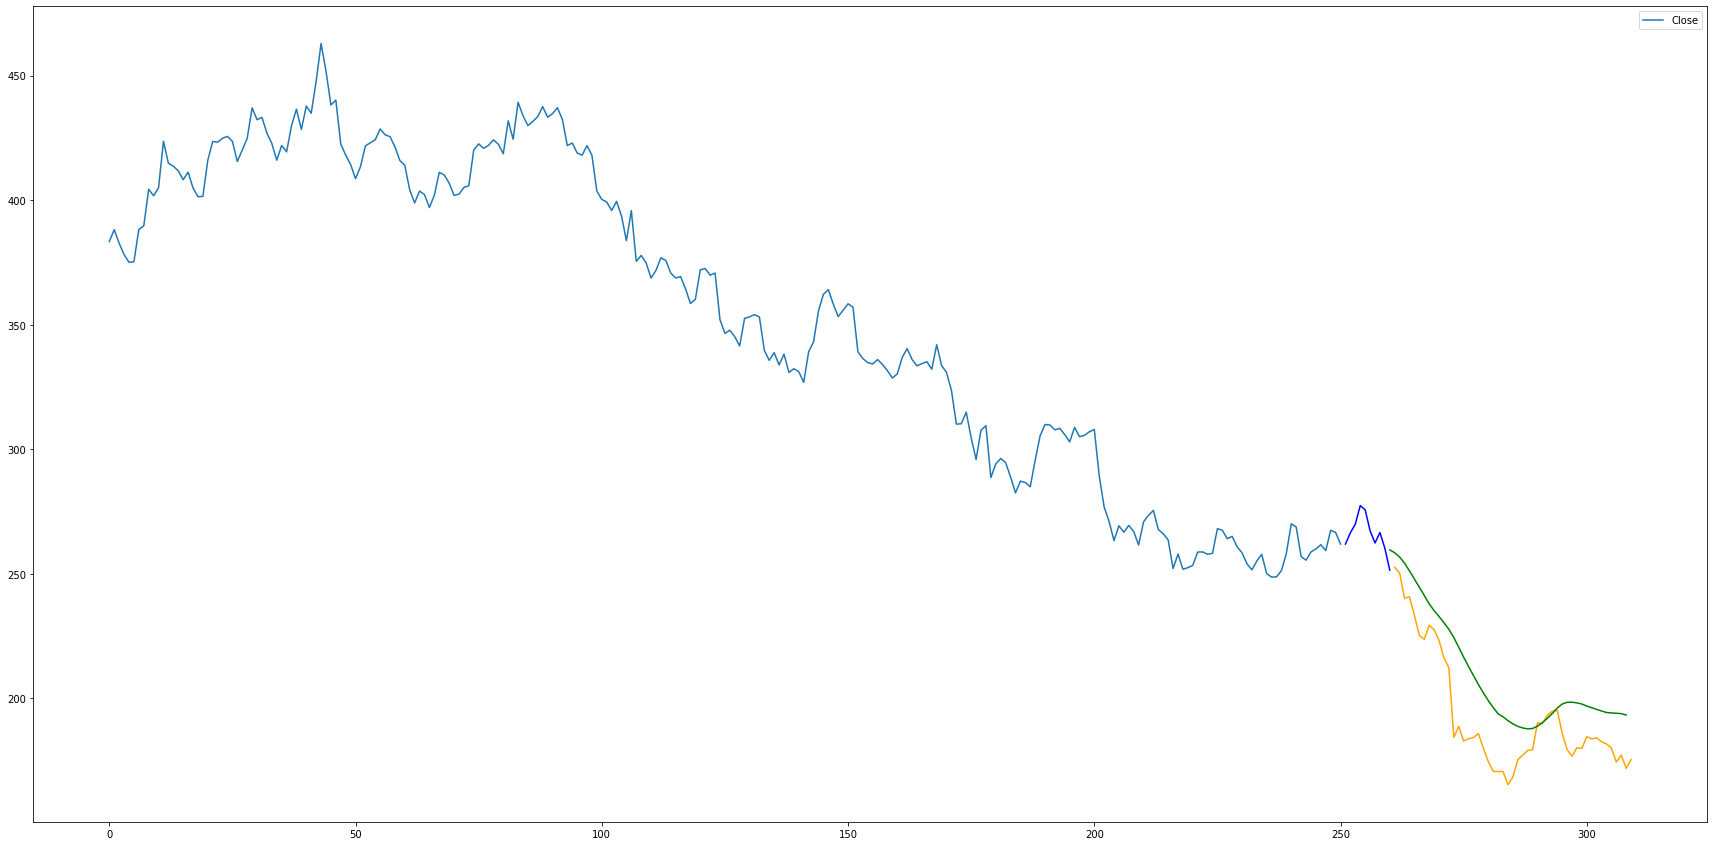

In [29]:
tata_model_plt = tata_train_plot_copy.plot(y=['Close'], figsize=(30,15))
tata_model_plt.plot(tata_test_plot_copy["Close"][:10], c='blue')
tata_model_plt.plot(tata_test_plot_copy["Close"][10:], c='orange')
tata_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
tata_predictions_df = pd.read_csv('Tata_predicitions.csv')
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-01-08,433.549988,259.002342,263.351346
1,2018-01-09,437.549988,258.402641,265.761722
2,2018-01-10,433.299988,257.802941,265.536848
3,2018-01-11,434.750000,257.203241,257.958445
4,2018-01-12,437.100006,255.744917,256.235580


In [31]:
tata_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
55,2018-04-02,339.149994,211.558413,266.080805
56,2018-04-03,343.100006,210.958713,262.214372
57,2018-04-04,355.600006,212.630090,266.232397
58,2018-04-05,362.200012,203.121363,267.181525
59,2018-04-06,364.100006,NaN,NaN


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,259.626282
11,258.466614
12,256.745300
13,254.282272
14,251.202026
15,247.915894
16,244.634232
17,241.325058
18,237.977097
19,235.188721


In [33]:
tata_predictions_df['LSTM_Close'] = closing_price_df['price']
tata_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2018-01-08,433.549988,259.002342,263.351346,NaN
1,2018-01-09,437.549988,258.402641,265.761722,NaN
2,2018-01-10,433.299988,257.802941,265.536848,NaN
3,2018-01-11,434.750000,257.203241,257.958445,NaN
4,2018-01-12,437.100006,255.744917,256.235580,NaN
5,2018-01-15,432.350006,255.145217,257.217947,NaN
6,2018-01-16,421.899994,254.545517,260.215778,NaN
7,2018-01-17,422.950012,253.346116,261.763943,NaN
8,2018-01-18,418.950012,251.887793,258.218134,NaN
9,2018-01-19,418.049988,251.288092,261.508583,NaN


In [34]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)